<a href="https://colab.research.google.com/github/paolapersico1/YelpSentimentAnalysis/blob/master/YelpSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**YELP SENTIMENT ANALYSIS**

#**Introduction**

The following project aims at automatically classifying Yelp reviews in two classes: positive and negative reviews, in order to create a model which can be used as foundation to perform sentiment analysis in contexts where a huge amount of unstructured data is available.

The Yelp Open Dataset provided by the popular crowdsourcing company contains the reviews of the businesses of different cities located in the US and in Canada, as well as the corresponding ratings given by the users [1], so it is possible to adopt a supervised learning approach.

The main steps are the following:


1.   Data pre-processing
2.   Feature extraction
3.   Classifier training
4.   Testing

While the pre-processing and classification steps are somewhat trivial because of the extensive literature about natural language processing, there are many different approaches regarding textual feature extraction and the perfomance varies widely between different tasks [2].  

Since we had limited memory resources (12 GB of RAM space and 15 GB of disk space), we discarded brute-force tecniques such as TF-IDF, which creates a dictionary based on term occurrence and rarity, and we used a word-embedding model called Word2Vec, which maps words into low-dimensional semantic vectors.

In [ ]:
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

**Data storage setting**

Input and output data is saved in a Google Drive space, in order to avoid repeating expensive computations.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
FOLDER = "/content/drive/My Drive/Datasets/reviews/"
MODEL_FOLDER = "/content/drive/My Drive/Models/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Libraries import**

The main libraries used are:


*   Pandas $\rightarrow$ dataset import 
*   Gensim $\rightarrow$ data pre-processing and feature extraction
*   Scikit-learn $\rightarrow$ classification



In [ ]:
import pandas as pd
import numpy as np
import gensim
import matplotlib.pyplot as plt 
import time
import os
from joblib import dump, load
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier 
from sklearn import metrics

# **Data pre-processing**

Data pre-processing is an important step because of the "Garbage In Garbage Out" principle: quality data is necessary for quality models. 

**Dataset Import**

In order to avoid a RAM overflow, the 6 GB json dataset is read in chunks of 1 million rows; useless columns and rows with missing values are dropped; and only the first chunk is converted to csv.

In [ ]:
def load_yelp_data(output_filename, limit = False, chunksize = 1000000):
  review = pd.read_json(FOLDER + "yelp_academic_dataset_review.json", lines=True,
                        dtype={'review_id':str,'user_id':str,
                              'business_id':str,'stars':int,
                              'useful':int,'funny':int,'cool':int,
                              'text':str,'date':str},
                        chunksize=chunksize)
  
  # There are multiple chunks to be read
  chunk_list = []
  for chunk_review in review:
    # Drop columns that aren't needed
    chunk_review = chunk_review.drop(['review_id', 'user_id', 'business_id', 'useful', 'funny', 'cool', 'date'], axis=1)
    # Drop rows with missing values
    chunk_review = chunk_review.dropna()
    # Add chunk
    chunk_list.append(chunk_review)
    if limit and len(chunk_list) == limit:
      break
  # Concatenate the trimmed chunks to one dataframe
  df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)
  # convert to csv
  df.to_csv(output_filename, index=False)

# load the csv
yelp_reviews_csv = FOLDER + "yelp_reviews.csv"
if os.path.isfile(yelp_reviews_csv) and os.access(yelp_reviews_csv, os.R_OK):
    print("File exists and is readable")
else:
  print("Either the file is missing or not readable, we create a new one")
  load_yelp_data(yelp_reviews_csv, limit = 1)

# read the csv
df = pd.read_csv(yelp_reviews_csv)
print("The dataset is ready to be used")


File exists and is readable
The dataset is ready to be used


**Examples labeling**

A sentiment column whose value depends on the "stars" given by the author of the review is added. We consider reviews with 1-2 stars as negative and reviews with 4-5 stars as positive. 

Plotting the sentiment distribution, it is clear that negative and neutral reviews are outnumbered by positive reviews.

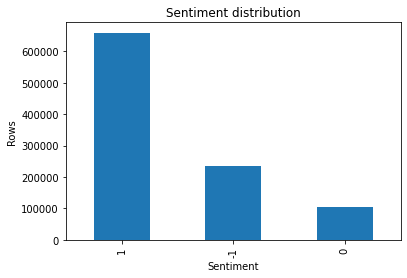

In [ ]:
# Function to convert stars to sentiment
def get_sentiment(stars):
  if stars <= 2:
      return -1               #negative review
  elif stars == 3:
      return 0                #neutral review
  else:
      return 1                #positive review

# convert stars to sentiment for each row
df['sentiment'] = [ get_sentiment(x) for x in df['stars']]

# Plot the sentiment distribution
plt.figure()
pd.value_counts(df['sentiment']).plot.bar(title="Sentiment distribution")
plt.xlabel("Sentiment")
plt.ylabel("Rows")
plt.show()

**Dataset balancing**

Since most classification models work better when the examples are balanced and since our RAM can't handle 1 million examples, we take only the first 200.000 positive reviews and the first 200.000 negative reviews.

In [ ]:
# Function to retrieve only a part of the positive and negative reviews
def get_data(rows):
    df_positive = df[df['sentiment'] == 1].head(rows)
    df_negative = df[df['sentiment'] == -1].head(rows)
    df_balanced = pd.concat([df_positive, df_negative])
    return df_balanced

df_balanced = get_data(200000)

**Tokenization**

Each review is converted into a list of lowercase tokens and accent marks are removed.

In [ ]:
# Tokenize each review
df_balanced['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in df_balanced['text']] 

**Stemming**

Every token is stemmed to its root, e.g. "consultant" and "consulting" are both stemmed to "consult".

In [ ]:
# Stem each word in each review
porter_stemmer = PorterStemmer()
df_balanced['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in df_balanced['tokenized_text']]

#**Feature Extraction**

Feature extraction is necessary because we need to transform each list of strings into a representation suitable for the learning algorithm. To be exact, each distinct word in the vocabulary has to correspond to a numerical feature. As already stated in the introduction, we focused on a dense representation (i.e. word-embeddings) instead of a sparse representation because of efficiency reasons.


**Word2Vec**

Word2Vec is a set of models to generate word embeddings (mapping of words into vectors of real numbers) developed by Google in 2013 [3]. Embeddings generated by Word2vec allow **semantic analysis**, since similar words have similar embeddings.

Word2Vec learning is based on Distributional Hypothesis:
> "A word is characterized by the company it keeps"
(J. R. Firth)

Word2Vec include two models, both based on two-layer neural networks:
*   **Skip-Gram** (SG), which predicts the context given a word as input
*   **Continuous Bag-of-Words** (CBOW), which does the opposite

Skip-gram works by training a neural network to solve the task of predicting context words given an input word (center word). The neural network computes probabilities related to how likely it is find each vocabulary word nearby the center word. To be exact, given a word pair as example, it tries to maximize the probability of them being in the same context, which is defined using the softmax function. Actually, the goal is just to learn the weights of the hidden layer, which are the “word vectors” we are looking for.

According to the authors, Skip-Gram is a little bit slower but works better with uncommon words [4].


**Word2Vec model training** 

We train the Word2Vec model with Skip-Gram on the stemmed tokens, generating for each distint term a 300 elements vector. This value has been chosen because lower values lead to a worse accuracy and higher values (up to 400) didn't improve accuracy and severely worsened efficiency. 
In general, the optimal vector size depends on the dataset size [5].

Three model files are generated and stored for later use:

*   word2vec_model
*   word2vec_model.trainables.syn1neg
*   word2vec_model.wv.vectors



In [ ]:
word2vec_model_file = MODEL_FOLDER + 'word2vec_model'
if os.path.isfile(word2vec_model_file) and os.access(word2vec_model_file, os.R_OK):
    print("File exists and is readable")
else:
  print("Either the file is missing or not readable, we create a new one")
  size = 300    #dim of word vectors
  window = 5    #context window
  min_count = 1 #do not ignore words with low frequency
  workers = 3   #training threads
  sg = 1        #Skip-gram model

  start_time = time.time()
  # turn the list of tokens into a ndarray
  stemmed_tokens = pd.Series(df_balanced['stemmed_tokens']).values
  # train the Word2Vec model
  w2v_model = Word2Vec(stemmed_tokens, min_count = min_count, size = size, workers = workers, window = window, sg = sg)
  print("Time taken to train word2vec model: " + str(time.time() - start_time))
  w2v_model.save(word2vec_model_file)

# load the model 
w2v_model = Word2Vec.load(word2vec_model_file)

File exists and is readable


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


**Training/testing dataset splitting**

The dataset is randomly shuffled and splitted into 60% training dataset and 20% validation dataset to tune the model parameters and 20% testing dataset to perform hold-out testing, which is efficient and gives a good estimate of the model performance when the dataset is large enough. 

In [ ]:
# Function to split the dataset into train and test datasets
def split_dataset(df_balanced, test_size=0.2, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(df_balanced[['stars', 'stemmed_tokens']], 
                                                        df_balanced['sentiment'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    
    #testing dataset ratio = 0.25 * (1-0.2) = 0.2
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, 
                                                      Y_train, 
                                                      shuffle=shuffle_state, 
                                                      test_size=0.25, 
                                                      random_state=1)

    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    X_val = X_val.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    Y_val = Y_val.to_frame()
    Y_val = Y_val.reset_index()
    return X_train, X_test, Y_train, Y_test, X_val, Y_val

# split the dataset
X_train, X_test, Y_train, Y_test, X_val, Y_val = split_dataset(df_balanced)

**Word-embeddings datasets generation**

Each review is converted from a list of stemmed tokens to a vector of floating point numbers, which is obtained computing the mean of the word embeddings of each stemmed tokens. If non-valid values are encountered, the mean vector is a vector of all 0s, which doesn't affect the classification.

In [ ]:
def get_word2vec_dataset(dataset, filename):
  word2vec_filename = FOLDER + filename
  if os.path.isfile(word2vec_filename) and os.access(word2vec_filename, os.R_OK):
      print("File exists and is readable")
  else:
    print("Either the file is missing or not readable, we create a new one")
    # Store the vectors for data in a file
    with open(word2vec_filename, 'w+') as word2vec_file:
        for index, row in dataset.iterrows():
            #average over all the word2vec embeddings of the review
            model_vector = (np.mean([w2v_model[token] for token in row['stemmed_tokens']], axis=0)).tolist()
            if index == 0:
                header = ",".join(str(ele) for ele in range(300))
                word2vec_file.write(header)
                word2vec_file.write("\n")
            # Check if the line exists else it is vector of zeros
            if type(model_vector) is list:  
                line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
            else:
                line1 = ",".join([str(0) for i in range(300)])
            word2vec_file.write(line1)
            word2vec_file.write('\n')

  # Load from the filename
  df = pd.read_csv(word2vec_filename)
  print("The " + filename + " dataset is ready to be used")
  return df

#retrieve the word2vec train dataset
train_df = get_word2vec_dataset(X_train, 'train_review.csv')
#retrieve the word2vec validation dataset
val_df = get_word2vec_dataset(X_val, 'val_review.csv')
#retrieve the word2vec test dataset
test_df = get_word2vec_dataset(X_test, 'test_review.csv')

File exists and is readable
The train_review.csv dataset is ready to be used
File exists and is readable
The val_review.csv dataset is ready to be used
File exists and is readable
The test_review.csv dataset is ready to be used


#**Classifiers Training**

We train some of the most used models in NLP tasks:


*   Naive Bayes
*   Random Forest
*   Multi-Layer Perceptron
*   Support Vector Classifier



**Naive Bayes** 

The Naive Bayes classifier identify the class by computing the conditional probabilities that a certain input belongs to the different classes and selecting the class which gives the greatest probability.

In [ ]:
#Initialize the Naive Bayes model
nb_classifier = GaussianNB()

start_time = time.time()
# Fit the model
nb_classifier.fit(train_df, Y_train['sentiment'])
print('Training time: ' + str(time.time() - start_time))
dump(nb_classifier, MODEL_FOLDER + 'nb_classifier.joblib') 

Training time: 2.4838268756866455


['/content/drive/My Drive/Models/nb_classifier.joblib']

**Random Forest**

The Random Forest classifier is an ensemble learning algorithm based on aggregating the votes of several different decision trees (generated by manipulating the training dataset using a tecnique called "random sampling with replacement"). We used the validation dataset to choose the number of trees. 

In [ ]:
#Initialize the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=150, random_state=15)

start_time = time.time()
# Fit the model
rf_classifier.fit(train_df, Y_train['sentiment'])
print('Training time: ' + str(time.time() - start_time))
dump(rf_classifier, MODEL_FOLDER + 'rf_classifier.joblib') 

Training time: 1196.9854400157928


['/content/drive/My Drive/Models/rf_classifier.joblib']

**Multi-Layer Perceptron**

The Multi-Layer Perceptron is a feed-forward neural network with one or more hidden layers. Here we use the stochastic gradient descent for weight updating with 2 hidden layers and 301 (number of features + bias) hidden units.

In [ ]:
#Initialize the MLP model
mlp_classifier = MLPClassifier(solver='sgd', hidden_layer_sizes=(301,2), alpha=1e-4, random_state=15)

start_time = time.time()
# Fit the model
mlp_classifier.fit(train_df, Y_train['sentiment'])
print('Training time: ' + str(time.time() - start_time))
dump(mlp_classifier, MODEL_FOLDER + 'mlp_classifier.joblib') 

Training time: 1851.3191394805908


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


['/content/drive/My Drive/Models/mlp_classifier.joblib']

**Support Vector Classifier**

The support vector classifier treats examples as points and computes the hyperplanes that best allow to separate data of different classes, and has the advantage that it avoids overfitting by allowing some misclassifications for outliers.

In [ ]:
#Initialize the SVC model
svc_classifier = LinearSVC(dual=False)

start_time = time.time()
# Fit the model
svc_classifier.fit(train_df, Y_train['sentiment'])
print('Training time: ' + str(time.time() - start_time))
dump(svc_classifier, MODEL_FOLDER + 'svc_classifier.joblib') 

Training time: 21.15547227859497


['/content/drive/My Drive/Models/svc_classifier.joblib']

#**Classifiers Testing**

The last step is testing all the classifiers and comparing their performance using different criterias: accuracy, precision, recall and number of errors. 

In [ ]:
accuracy_dict = {}
precision_dict = {}
recall_dict = {}
f1_dict = {}
fp_dict = {}
fn_dict = {}

In [ ]:
def get_metrics(classifier, name, validation=False):

  if validation == True:
      prediction_df = val_df
      Y_set = Y_val
  else:
      prediction_df = test_df
      Y_set = Y_test

  test_predictions = classifier.predict(prediction_df)

  accuracy_dict[name] = metrics.accuracy_score(Y_set['sentiment'], test_predictions)
  precision_dict[name] = metrics.precision_score(Y_set['sentiment'], test_predictions)
  recall_dict[name] = metrics.recall_score(Y_set['sentiment'], test_predictions)
  f1_dict[name] = metrics.f1_score(Y_set['sentiment'], test_predictions)

  #get false positives and false negatives
  tn, fp, fn, tp = metrics.confusion_matrix(Y_set['sentiment'], test_predictions).ravel()
  fp_dict[name] = fp
  fn_dict[name] = fn  

In [ ]:
#Naive Bayes
nb_classifier = load(MODEL_FOLDER + 'nb_classifier.joblib') 
get_metrics(nb_classifier, "Naive Bayes")

In [ ]:
#Random Forest
rf_classifier = load(MODEL_FOLDER + 'rf_classifier.joblib') 
get_metrics(rf_classifier, "Random Forest")

In [ ]:
#Multi-Layer Perceptron
mlp_classifier = load(MODEL_FOLDER + 'mlp_classifier.joblib') 
get_metrics(mlp_classifier, "MLP")

In [ ]:
#SVC
svc_classifier = load(MODEL_FOLDER + 'svc_classifier.joblib') 
get_metrics(svc_classifier, "SVC")

In [ ]:
#Function to bar plot a metric for each classifier
def plot_dict(dict, metric_name):
  label = dict.keys()
  rng = range(len(label))
  plt.xticks(rng, label)
  p = plt.bar(rng, dict.values(), 0.4)
  plt.ylabel(metric_name)
  plt.xlabel('Classifier')

  #print also the metric (up to 5 decimals) on top
  for i, v in enumerate(dict.values()):
    plt.text(rng[i] - 0.25, v + 0.01, str(f"{v:.5f}"))

  plt.show()

**Accuracy**

Accuracy is the number of correctly predicted instances out of all the instances.

$Accuracy = \dfrac{TP+TN}{TP+TN+FP+FN}$

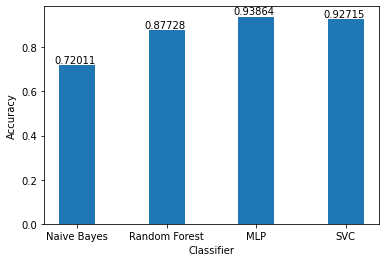

In [ ]:
#plot the accuracy
plot_dict(accuracy_dict, "Accuracy")

**Precision**

Precision is the fraction of correctly predicted positive instances out of all instances classified as positive.

$Precision = \dfrac{TP}{TP+FP}$

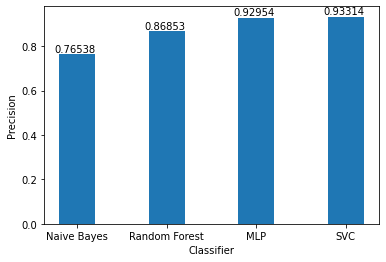

In [ ]:
#plot the precision
plot_dict(precision_dict, "Precision")

**Recall**

Recall is the fraction of correctly predicted positive instances out of all positive instances.

$Recall = \dfrac{TP}{TP+FN}$

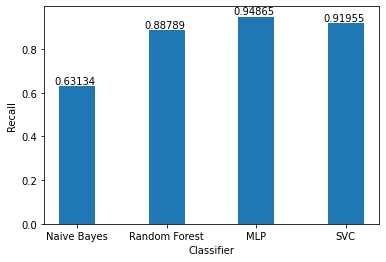

In [ ]:
#plot the recall
plot_dict(recall_dict, "Recall")

**F1 score**

The F1 score is the harmonic mean of precision and recall.

$F1 = 2 * \dfrac{Precision * Recall}{Precision + Recall}$

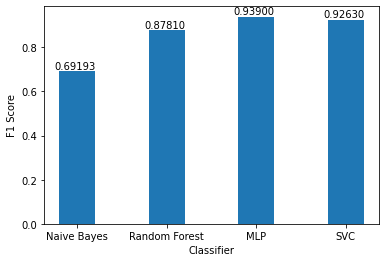

In [ ]:
plot_dict(f1_dict, "F1 Score")

**Errors**

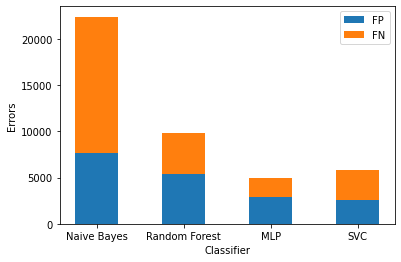

In [ ]:
#plot the errors using a stacked bar plot
label = fp_dict.keys()
rng = range(len(label))
plt.xticks(rng, label)
#false positives
p1 = plt.bar(rng, fp_dict.values(), 0.5)
#false negatives
p2 = plt.bar(rng, fn_dict.values(), 0.5, bottom = list(fp_dict.values()))
plt.ylabel('Errors')
plt.xlabel('Classifier')
plt.legend((p1[0], p2[0]), ('FP', 'FN'))
plt.show()

#**Conclusion**

The evaluation results are very satisfactory considering the memory constraints, as the accuracy reached using Word2Vec and MLP is 0.94. A similar result is also obtained using SVC, which can be trained faster. 

Further improvements can be made not only by increasing the training dataset size, but also during the pre-processing phase, removing reviews in foreign languages and correcting spelling mistakes. It would also be interesting to compare the performance of Word2Vec to other word embeddings algorithms like GloVe.
 

#**References**

[1] Yelp Documentation. Yelp. Retrieved from https://www.yelp.com/dataset/documentation/main

[2] Dipika Baad. 2020. *Sentiment Classification using Word Embeddings (Word2Vec)*. Retrieved from https://medium.com/swlh/sentiment-classification-using-word-embeddings-word2vec-aedf28fbb8ca

[3] Tomas Mikolov, Kai Chen, Greg Corrado, Jeffrey Dean. 2013. *Efficient Estimation of Word Representations in Vector Space*. Proceedings of the International Conference on Learning Representations.

[4] Word2Vec. Google Code. Retrieved from https://code.google.com/archive/p/word2vec/

[5] Rizka Putri Nawangsari, Retno Kusumaningrum, Adi Wibowo. 2019. *Word2Vec for Indonesian Sentiment Analysis towards Hotel Reviews: An Evaluation Study*. Procedia Computer Science. 